In [1]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from cv_paper_plots import accuracy, slope, analysis

from cv_paper_plots.style import letter_fontstyle, subject_labels

from importlib import reload

import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot

/home/jesse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
subjects = ['ec2', 'ec9', 'gp31', 'gp33']

In [3]:
with open(os.path.join(os.environ['HOME'], 'plots/model/data/frac_results.pkl'), 'rb') as f:
    deep_all, linear_all, _ = pickle.load(f, encoding='latin1')

d = np.load(os.path.join(os.environ['HOME'], 'plots/ds/data/dataset_chance.npz'))
chance = d['chance_data']
training_size = d['training_size']
fracs = sorted(deep_all.keys())

In [4]:
other_linear_accuracy = {}
other_deep_accuracy = {}
linear_cv_mats = {}
deep_cv_mats = {}
linear_c_mats = {}
deep_c_mats = {}
linear_v_mats = {}
deep_v_mats = {}
deep_cv_stats = {}
linear_cv_stats = {}
for key in ['c', 'v', 'p', 'm']:
    other_linear_accuracy[key] = np.zeros((len(subjects), 3, 10))
    other_deep_accuracy[key] = np.zeros((len(subjects), 3, 10))
for key in ['sens', 'spec', 'prec', 'f1']:
    deep_cv_stats[key] = np.zeros((len(subjects), 10))
    linear_cv_stats[key] = np.zeros((len(subjects), 10))
for ii, s in enumerate(subjects):
    for style in ['_lin', '']:
        f_string = 'plots/model/data/{}_{}_hg_a{}_model_output.pkl'.format(s, s, style)
        with open(os.path.join(os.environ['HOME'], f_string), 'rb') as f:
            dicts, dicts2, y_dims, has_data = pickle.load(f, encoding='latin1')
        indices_dicts2, y_hat_dicts2, logits_dicts2 = dicts2
        mats = analysis.indx_dict2conf_mat(indices_dicts2, y_dims)
        c_mat, v_mat, cv_mat = mats
        acc = analysis.conf_mat2accuracy(c_mat, v_mat, cv_mat)
        acc, (cv_sens, cv_spec, cv_prec, cv_f1) = acc
        (c_accuracy, v_accuracy, accuracy_per_cv,
         p_accuracy, m_accuracy) = acc
        cv_mat_r = analysis.indx_dict2reduced_cv_conf_mat(dicts[1],
                                                          list(dicts[1][0].values())[0][0].max()+1)
        if style == '_lin':
            d = other_linear_accuracy
            mat_d = linear_cv_mats
            mat_d_c = linear_c_mats
            mat_d_v = linear_v_mats
            stats_d = linear_cv_stats
        else:
            d = other_deep_accuracy
            mat_d = deep_cv_mats
            mat_d_c = deep_c_mats
            mat_d_v = deep_v_mats
            stats_d = deep_cv_stats
        d['c'][ii, 2] = c_accuracy
        d['v'][ii, 2] = v_accuracy
        d['p'][ii, 2] = p_accuracy
        d['m'][ii, 2] = m_accuracy
        mat_d[s] = cv_mat_r
        mat_d_c[s] = c_mat
        mat_d_v[s] = v_mat
        stats_d['sens'][ii] = cv_sens
        stats_d['spec'][ii] = cv_spec
        stats_d['prec'][ii] = cv_prec
        stats_d['f1'][ii] = cv_f1

# CV Accuracy

Subject 1: p=0.020248128505071458, hg: 21.545827889245718, delta: 8.311071833537618
Subject 2: p=0.8540974161447297, hg: 3.3013573101769986, delta: 0.4751119508076225
Subject 3: p=0.020248128505071458, hg: 6.034071580498386, delta: 1.7141420286131783
Subject 4: p=0.020248128505071458, hg: 13.34824907841502, delta: 4.786736110474774
all subject: p=1.4069613793016899e-06
The highest deep network accuracy for a single subject on the consonant vowel task is for Subject 1 which is 38.3 $\pm$ 2.9\% (21.5 times chance, 1.8\%) and 23.6 $\pm$ 2.1\% (13.2 times chance, 1.8\%) for logistic regression and deep networks respectively, which is a 63.1\% improvement. Mean consonant vowel classification accuracy across subjects (XX way) with deep networks is 19.9 $\pm$ 12.6\%. For logistic regression, it is 13.1 $\pm$ 7.4\%.



/home/jesse/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


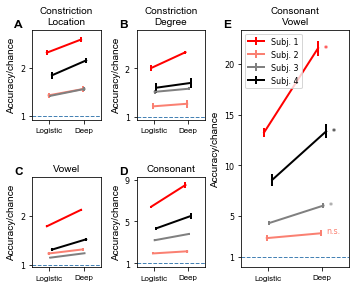

In [6]:
reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(5, 4))

le = .1
re = .02
te = .1
be = .075
h_gap = .1
v_gap = .2

cv_w = .3
big_h = (1. - te - be)
little_h = (1. - te - be - v_gap) / 2.
w = (1. - le - cv_w - h_gap - h_gap - re) / 2.

p_m_y = be + little_h + v_gap
ax_p = f.add_axes([le, p_m_y, w, little_h])
ax_m = f.add_axes([le + w + h_gap, p_m_y, w, little_h])

ax_v = f.add_axes([le, be, w, little_h])
ax_c = f.add_axes([le + w + h_gap, be, w, little_h])

ax_cv = f.add_axes([1. - re - cv_w, be, cv_w, big_h])

key = fracs[-1]

accuracy.plot_cv_accuracy(subjects, deep_all[key], linear_all[key], chance[0, :, -1], ax_cv, legend=True,
                          show_significance=True)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['c'], other_linear_accuracy['c'],
                          chance[1, :, -1], ax_c, 'Consonant', False, ymax=9.2)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['v'], other_linear_accuracy['v'],
                          chance[2, :, -1], ax_v, 'Vowel', False, ymax=2.8)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['p'], other_linear_accuracy['p'],
                          chance[3, :, -1], ax_p, 'Constriction\nLocation', False, ymax=2.8)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['m'], other_linear_accuracy['m'],
                          chance[4, :, -1], ax_m, 'Constriction\nDegree', False, ymax=2.8)

x0 = le - .05
y0 = p_m_y + little_h + .01
x1 = le + w + h_gap - .05
y1 = be + little_h + .01
x2 = 1. - re - cv_w - .05

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)
f.text(x0, y1, 'C', **letter_fontstyle)
f.text(x1, y1, 'D', **letter_fontstyle)
f.text(x2, y0, 'E', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy.eps'), dpi=300)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy.png'), dpi=300)

# ANOVA improvement dependence on subject, model, task

In [20]:
accuracies = []

ch = chance[0, :, -1].mean(axis=-1)
da = deep_all[key][:, -1] / ch
la = linear_all[key][:, -1] / ch

for ii in range(4):
    for jj in range(10):
        accuracies.append({'subject':ii, 'accuracy':da[ii, jj],
                           'complexity': 3, 'model': 2})
        accuracies.append({'subject':ii, 'accuracy':la[ii, jj],
                           'complexity': 3, 'model': 1})
    
ch = chance[1, :, -1].mean(axis=-1)
da = other_deep_accuracy['c'][:, -1] / ch
la = other_linear_accuracy['c'][:, -1] / ch
for ii in range(4):
    for jj in range(10):
        accuracies.append({'subject':ii, 'accuracy':da[ii, jj],
                           'complexity': 2, 'model': 2})
        accuracies.append({'subject':ii, 'accuracy':la[ii, jj],
                           'complexity': 2, 'model': 1})

for ii, t in enumerate(['v', 'p', 'm']):
    ch = chance[ii+2, :, -1].mean(axis=-1)
    da = other_deep_accuracy[t][:, -1] / ch
    la = other_linear_accuracy[t][:, -1] / ch
    for ii in range(4):
        for jj in range(10):
            accuracies.append({'subject':ii, 'accuracy':da[ii, jj],
                               'complexity': 1, 'model': 2})
            accuracies.append({'subject':ii, 'accuracy':la[ii, jj],
                               'complexity': 1, 'model': 1})
df = pd.DataFrame.from_dict(accuracies)

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     115.8
Date:                Mon, 27 Aug 2018   Prob (F-statistic):           3.45e-98
Time:                        14:43:43   Log-Likelihood:                -896.49
No. Observations:                 400   AIC:                             1811.
Df Residuals:                     391   BIC:                             1847.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

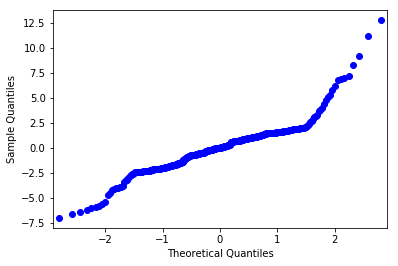

In [21]:
formula = "accuracy ~ C(subject, Treatment(0)) + C(complexity, Treatment(3)) * C(model, Treatment(1))"
lm = ols(formula, df)
fit = lm.fit()
qqplot(fit.resid)
print(fit.summary())
print('\nThe accuracy of the classifier depends on the subject, ' +
      'model type (deep network versus logistic regression), ' +
      'and task complexity (CV versus consonant versus {vowel, location, degree}) ' +
      '(ANOVA with subject, model type, task complexity, and model-task complexity interaction, ' +
      'f-value: {}, p: {}). '.format(fit.fvalue, fit.f_pvalue) +
      'Within this ANOVA, all treatment coefficients were significant ' +
      'at p<.001 with Subject 1, CV task, and logistic regression as the baseline.')
for table in fit.summary().tables:
    print(table.as_latex_tabular())
plt.show()

In [9]:
s = fit.summary()

# Results table

In [9]:
dcv_acc = deep_all[fracs[-1]][:, 2] * 100.
lcv_acc = linear_all[fracs[-1]][:, 2] * 100.
cv_chance = chance[0, :, -1].mean(axis=-1) * 100.
dcv_cc = np.zeros(4)
dcv_ncc = np.zeros(4)
lcv_cc = np.zeros(4)
lcv_ncc = np.zeros(4)

dc_acc = other_deep_accuracy['c'][:, 2] * 100.
lc_acc = other_linear_accuracy['c'][:, 2] * 100.
c_chance = chance[1, :, -1].mean(axis=-1) * 100.
dc_cc = np.zeros(4)
dc_ncc = np.zeros(4)
lc_cc = np.zeros(4)
lc_ncc = np.zeros(4)

dv_acc = other_deep_accuracy['v'][:, 2] * 100.
lv_acc = other_linear_accuracy['v'][:, 2] * 100.
v_chance = chance[2, :, -1].mean(axis=-1) * 100.
dv_cc = np.zeros(4)
dv_ncc = np.zeros(4)
lv_cc = np.zeros(4)
lv_ncc = np.zeros(4)

for ii, s in enumerate(subjects):
    print(deep_cv_mats[s].shape)
    dcv_cc[ii] = accuracy.channel_capacity(deep_cv_mats[s].mean(axis=0))
    dcv_ncc[ii] = accuracy.naive_channel_capacity(dcv_acc[ii].mean()/100., deep_cv_mats[s].shape[-1]+1)
    lcv_cc[ii] = accuracy.channel_capacity(linear_cv_mats[s].mean(axis=0))
    lcv_ncc[ii] = accuracy.naive_channel_capacity(lcv_acc[ii].mean()/100., linear_cv_mats[s].shape[-1]+1)
    
    dc_cc[ii] = accuracy.channel_capacity(deep_c_mats[s].mean(axis=0))
    dc_ncc[ii] = accuracy.naive_channel_capacity(dc_acc[ii].mean()/100., deep_c_mats[s].shape[-1]+1)
    lc_cc[ii] = accuracy.channel_capacity(linear_c_mats[s].mean(axis=0))
    lc_ncc[ii] = accuracy.naive_channel_capacity(lc_acc[ii].mean()/100., linear_c_mats[s].shape[-1]+1)
    
    dv_cc[ii] = accuracy.channel_capacity(deep_v_mats[s].mean(axis=0))
    dv_ncc[ii] = accuracy.naive_channel_capacity(dv_acc[ii].mean()/100., deep_v_mats[s].shape[-1]+1)
    lv_cc[ii] = accuracy.channel_capacity(linear_v_mats[s].mean(axis=0))
    lv_ncc[ii] = accuracy.naive_channel_capacity(lv_acc[ii].mean()/100., linear_v_mats[s].shape[-1]+1)

(10, 57, 57)


/home/jesse/Development/cv_paper_plots/cv_paper_plots/accuracy.py:95: RuntimeWarning: invalid value encountered in true_divide
  Iyhy = Pyhy * Py * np.log2(Pyhy/Pyh)
/home/jesse/Development/cv_paper_plots/cv_paper_plots/accuracy.py:95: RuntimeWarning: divide by zero encountered in log2
  Iyhy = Pyhy * Py * np.log2(Pyhy/Pyh)
/home/jesse/Development/cv_paper_plots/cv_paper_plots/accuracy.py:95: RuntimeWarning: invalid value encountered in multiply
  Iyhy = Pyhy * Py * np.log2(Pyhy/Pyh)


(10, 56, 56)
(10, 54, 54)
(10, 57, 57)


In [10]:
mugler2014 = {'consonant_single': 36.1,
              'consonant_avg': 20.4,
              'consonant_avg_pm': 9.8,
              'consonant_chance': 7.4,
              'vowel_single': 23.9,
              'vowel_avg': 19.2,
              'vowel_avg_pm': 3.7,
              'vowel_chance': 12.9}
mugler2014['consonant_single_cc'] = accuracy.naive_channel_capacity(mugler2014['consonant_single']/100., 24)
mugler2014['consonant_avg_cc'] = accuracy.naive_channel_capacity(mugler2014['consonant_avg']/100., 24)
mugler2014['vowel_single_cc'] = accuracy.naive_channel_capacity(mugler2014['vowel_single']/100., 15)
mugler2014['vowel_avg_cc'] = accuracy.naive_channel_capacity(mugler2014['vowel_avg']/100., 15)

def format_string(string, *data):
    acc, std, ac, ncc, cc = data
    return string.format(np.around(acc, 1), np.around(std, 1), np.around(ac, 1), np.around(ncc, 2), np.around(cc, 2))

d_cv1 = "Deep network, 57 CV, single subj.         &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
d_cv2 = "Deep network, 57 CV, subj. average        &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
d_cv1 = format_string(d_cv1, dcv_acc[0].mean(), dcv_acc[0].std(),
                      (dcv_acc[0]/cv_chance[0]).mean(),
                      dcv_ncc[0], dcv_cc[0])
d_cv2 = format_string(d_cv2, dcv_acc.mean(), dcv_acc.std(),
                      (dcv_acc/cv_chance).mean(),
                      dcv_ncc.mean(), dcv_cc.mean())
l_cv1 = "Logistic Regression, 57 CV, single subj.  &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
l_cv2 = "Logistic Regression, 57 CV, subj. average &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
l_cv1 = format_string(l_cv1, lcv_acc[0].mean(), lcv_acc[0].std(),
                      (lcv_acc[0]/cv_chance[0]).mean(),
                      lcv_ncc[0], lcv_cc[0])
l_cv2 = format_string(l_cv2, lcv_acc.mean(), lcv_acc.std(),
                      (lcv_acc/cv_chance).mean(),
                      lcv_ncc.mean(), lcv_cc.mean())
hline = "\\hline\n"
d_c1 = "Deep network, 19 cons., single subj.         &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
d_c2 = "Deep network, 19 cons., subj. average        &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
d_c1 = format_string(d_c1, dc_acc[0].mean(), dc_acc[0].std(),
                      (dc_acc[0]/c_chance[0]).mean(),
                      dc_ncc[0], dc_cc[0])
d_c2 = format_string(d_c2, dc_acc.mean(), dc_acc.std(),
                      (dc_acc/c_chance).mean(),
                      dc_ncc.mean(), dc_cc.mean())
l_c1 = "Logistic Regression, 19 cons., single subj.  &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
l_c2 = "Logistic Regression, 19 cons., subj. average &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
l_c1 = format_string(l_c1, lc_acc[0].mean(), lc_acc[0].std(),
                      (lc_acc[0]/c_chance[0]).mean(),
                      lc_ncc[0], lc_cc[0])
l_c2 = format_string(l_c2, lc_acc.mean(), lc_acc.std(),
                      (lc_acc/c_chance).mean(),
                      lc_ncc.mean(), lc_cc.mean())
m_c = ("LDA~\cite{{mugler2014}}, 24 cons., single subj.  &{}\% & {}x & {} \\\\\n" +
       "LDA~\cite{{mugler2014}}, 24 cons., subj. average &{} $\pm$ {}\% & {}x & {} \\\\\n")
m_c = m_c.format(np.around(mugler2014['consonant_single'], 1),
                 np.around(mugler2014['consonant_single']/mugler2014['consonant_chance'], 1),
                 np.around(mugler2014['consonant_single_cc'][0], 2),
                 np.around(mugler2014['consonant_avg'], 1),
                 np.around(mugler2014['consonant_avg_pm'], 1),
                 np.around(mugler2014['consonant_avg']/mugler2014['consonant_chance'], 1),
                 np.around(mugler2014['consonant_avg_cc'][0], 2))
d_v1 = "Deep network, 3 vowels, single subj.         &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
d_v2 = "Deep network, 3 vowels, subj. average        &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
d_v1 = format_string(d_v1, dv_acc[0].mean(), dv_acc[0].std(),
                      (dv_acc[0]/v_chance[0]).mean(),
                      dv_ncc[0], dv_cc[0])
d_v2 = format_string(d_v2, dv_acc.mean(), dv_acc.std(),
                      (dv_acc/v_chance).mean(),
                      dv_ncc.mean(), dv_cc.mean())
l_v1 = "Logistic Regression, 3 vowels, single subj.  &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
l_v2 = "Logistic Regression, 3 vowels, subj. average &{} $\pm$ {}\% & {}x & {} ({} exact) \\\\\n"
l_v1 = format_string(l_v1, lv_acc[0].mean(), lv_acc[0].std(),
                      (lv_acc[0]/v_chance[0]).mean(),
                      lv_ncc[0], lv_cc[0])
l_v2 = format_string(l_v2, lv_acc.mean(), lv_acc.std(),
                      (lv_acc/v_chance).mean(),
                      lv_ncc.mean(), lv_cc.mean())
m_v = ("LDA~\cite{{mugler2014}}, 15 vowels, single subj.  &{}\% & {}x & {} \\\\\n" +
       "LDA~\cite{{mugler2014}}, 15 vowels, subj. average &{} $\pm$ {}\% & {}x & {} \\\\\n")
m_v = m_v.format(np.around(mugler2014['vowel_single'], 1),
                 np.around(mugler2014['vowel_single']/mugler2014['vowel_chance'], 1),
                 np.around(mugler2014['vowel_single_cc'][0], 2),
                 np.around(mugler2014['vowel_avg'], 1),
                 np.around(mugler2014['vowel_avg_pm'], 1),
                 np.around(mugler2014['vowel_avg']/mugler2014['vowel_chance'], 1),
                 np.around(mugler2014['vowel_avg_cc'][0], 2))
print(d_cv1 + d_cv2 + l_cv1 + l_cv2 + hline +
      d_c1 + d_c2 + l_c1 + l_c2 + m_c + hline +
      d_v1 + d_v2 + l_v1 + l_v2 + m_v)

Deep network, 57 CV, single subj.         &38.3 $\pm$ 2.9\% & 21.5x & 1.3 (3.09 exact) \\
Deep network, 57 CV, subj. average        &19.9 $\pm$ 12.6\% & 11.1x & 0.53 (2.18 exact) \\
Logistic Regression, 57 CV, single subj.  &23.6 $\pm$ 2.1\% & 13.2x & 0.61 (2.47 exact) \\
Logistic Regression, 57 CV, subj. average &13.1 $\pm$ 7.4\% & 7.2x & 0.26 (1.91 exact) \\
\hline
Deep network, 19 cons., single subj.         &44.9 $\pm$ 3.0\% & 8.5x & 0.99 (1.9 exact) \\
Deep network, 19 cons., subj. average        &26.8 $\pm$ 12.6\% & 5.0x & 0.43 (1.03 exact) \\
Logistic Regression, 19 cons., single subj.  &34.0 $\pm$ 1.5\% & 6.4x & 0.59 (1.35 exact) \\
Logistic Regression, 19 cons., subj. average &21.4 $\pm$ 8.7\% & 4.0x & 0.27 (0.75 exact) \\
LDA~\cite{mugler2014}, 24 cons., single subj.  &36.1\% & 4.9x & 0.75 \\
LDA~\cite{mugler2014}, 24 cons., subj. average &20.4 $\pm$ 9.8\% & 2.8x & 0.25 \\
\hline
Deep network, 3 vowels, single subj.         &71.1 $\pm$ 1.9\% & 2.1x & 0.67 (0.44 exact) \\
Deep

# Results Table 2

In [12]:
for deep in [True, False]:
    for ii, s in enumerate(subjects):
        string = '{}, {}  '.format(subject_labels[s], 'deep' if deep else 'logistic')
        if deep:
            data = deep_all[1.][ii, 2]
        else:
            data = linear_all[1.][ii, 2]
        string = string + '&{} $\pm$ {}\%  '.format(np.around(100*data.mean(), 1),
                                                np.around(100*data.std(), 1))
        for key in ['sens', 'spec', 'prec', 'f1']:
            if deep:
                data = deep_cv_stats[key][ii]
            else:
                data = linear_cv_stats[key][ii]
            string = string + '&{} $\pm$ {}\%  '.format(np.around(100*data.mean(), 1),
                                                    np.around(100*data.std(), 1))
        string = string + ' \\\\'
        print(string)
    string = '{}, {}  '.format('Subj. average', 'deep' if deep else 'logistic')
    if deep:
        data = deep_all[1.][:, 2]
    else:
        data = linear_all[1.][:, 2]
    string = string + '&{} $\pm$ {}\%  '.format(np.around(100*data.mean(), 1),
                                            np.around(100*data.std(), 1))
    for key in ['sens', 'spec', 'prec', 'f1']:
        if deep:
            data = deep_cv_stats[key]
        else:
            data = linear_cv_stats[key]
        string = string + '&{} $\pm$ {}\%  '.format(np.around(100*data.mean(), 1),
                                                np.around(100*data.std(), 1))
    string = string + ' \\\\'
    print(string)
    print()

Subject 1, deep  &38.3 $\pm$ 2.9\%  &35.1 $\pm$ 2.6\%  &98.9 $\pm$ 0.0\%  &37.0 $\pm$ 3.9\%  &48.1 $\pm$ 4.2\%   \\
Subject 2, deep  &6.3 $\pm$ 1.5\%  &5.5 $\pm$ 2.0\%  &98.3 $\pm$ 0.0\%  &5.8 $\pm$ 2.3\%  &8.2 $\pm$ 2.8\%   \\
Subject 3, deep  &11.4 $\pm$ 1.2\%  &9.7 $\pm$ 1.1\%  &98.4 $\pm$ 0.0\%  &9.2 $\pm$ 1.5\%  &15.2 $\pm$ 2.1\%   \\
Subject 4, deep  &23.7 $\pm$ 3.7\%  &21.6 $\pm$ 4.3\%  &98.6 $\pm$ 0.1\%  &22.4 $\pm$ 5.7\%  &28.5 $\pm$ 6.3\%   \\
Subj. average, deep  &19.9 $\pm$ 12.6\%  &18.0 $\pm$ 11.8\%  &98.5 $\pm$ 0.2\%  &18.6 $\pm$ 12.8\%  &25.0 $\pm$ 15.8\%   \\

Subject 1, logistic  &23.6 $\pm$ 2.1\%  &23.3 $\pm$ 2.2\%  &98.6 $\pm$ 0.0\%  &24.1 $\pm$ 2.9\%  &33.8 $\pm$ 3.1\%   \\
Subject 2, logistic  &5.4 $\pm$ 1.9\%  &5.0 $\pm$ 1.7\%  &98.3 $\pm$ 0.0\%  &4.6 $\pm$ 1.7\%  &7.0 $\pm$ 2.5\%   \\
Subject 3, logistic  &8.2 $\pm$ 1.1\%  &8.0 $\pm$ 1.1\%  &98.4 $\pm$ 0.0\%  &7.8 $\pm$ 1.6\%  &13.1 $\pm$ 2.3\%   \\
Subject 4, logistic  &15.2 $\pm$ 3.2\%  &15.4 $\pm$ 3.4\%  &98.5

In [9]:
deep_all[1.][:, 2]

array([[0.37307686, 0.38846159, 0.37692308, 0.36538458, 0.42307693,
        0.37307692, 0.33076924, 0.44230765, 0.37692302, 0.38076925],
       [0.05696201, 0.05696201, 0.10126585, 0.05696201, 0.06329107,
        0.04430372, 0.06329107, 0.06962019, 0.05063289, 0.06329107],
       [0.11025143, 0.11411989, 0.13733071, 0.1083172 , 0.10444874,
        0.13539648, 0.11025137, 0.09671175, 0.11411989, 0.10831714],
       [0.26666671, 0.27407408, 0.2962963 , 0.18518519, 0.22962964,
        0.19259262, 0.25925934, 0.24444443, 0.18518519, 0.23703706]])

# CV Slope

                            OLS Regression Results                            
Dep. Variable:                  slope   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     35.54
Date:                Mon, 27 Aug 2018   Prob (F-statistic):           1.24e-16
Time:                        14:44:50   Log-Likelihood:                 143.85
No. Observations:                  80   AIC:                            -277.7
Df Residuals:                      75   BIC:                            -265.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

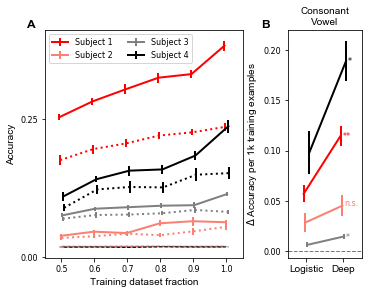

In [23]:
# reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(5, 4))

le = .1
re = .02
te = .1
be = .11
h_gap = .125

w = .55
h = 1. - te - be

ax_lines = f.add_axes([le, be, w, h])
ax_slopes = f.add_axes([le + w + h_gap, be, 1. - w - h_gap - le - re, h])

key = fracs[-1]

slope.plot_cv_slope(subjects, deep_all, linear_all, chance[0], training_size, fracs, (ax_lines, ax_slopes),
                    legend=True, show_significance=True)

x0 = .05
y0 = 1. - te + .01
x1 = le + w + h_gap - .075

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope.eps'), dpi=300)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope.png'), dpi=300)

# Accuracy Supplement

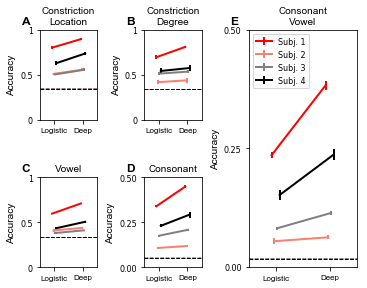

In [14]:
reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(5, 4))

le = .1
re = .02
te = .1
be = .075
h_gap = .13
v_gap = .2

cv_w = .3
big_h = (1. - te - be)
little_h = (1. - te - be - v_gap) / 2.
w = (1. - le - cv_w - h_gap - h_gap - re) / 2.

p_m_y = be + little_h + v_gap
ax_p = f.add_axes([le, p_m_y, w, little_h])
ax_m = f.add_axes([le + w + h_gap, p_m_y, w, little_h])

ax_v = f.add_axes([le, be, w, little_h])
ax_c = f.add_axes([le + w + h_gap, be, w, little_h])

ax_cv = f.add_axes([1. - re - cv_w, be, cv_w, big_h])

key = fracs[-1]

accuracy.plot_cv_accuracy(subjects, deep_all[key], linear_all[key], chance[0, :, -1], ax_cv, legend=True,
                          normalize_chance=False, ymax=.5)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['c'], other_linear_accuracy['c'],
                          chance[1, :, -1], ax_c, 'Consonant', False, ymax=.5, normalize_chance=False)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['v'], other_linear_accuracy['v'],
                          chance[2, :, -1], ax_v, 'Vowel', False, ymax=1, normalize_chance=False)

accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['p'], other_linear_accuracy['p'],
                          chance[3, :, -1], ax_p, 'Constriction\nLocation', False, ymax=1, normalize_chance=False)
accuracy.plot_cv_accuracy(subjects, other_deep_accuracy['m'], other_linear_accuracy['m'],
                          chance[4, :, -1], ax_m, 'Constriction\nDegree', False, ymax=1, normalize_chance=False)

x0 = le - .05
y0 = p_m_y + little_h + .02
x1 = le + w + h_gap - .05
y1 = be + little_h + .02
x2 = 1. - re - cv_w - .05

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)
f.text(x0, y1, 'C', **letter_fontstyle)
f.text(x1, y1, 'D', **letter_fontstyle)
f.text(x2, y0, 'E', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy2.eps'), dpi=300)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/accuracy2.png'), dpi=300)

# CV Slope Supplement

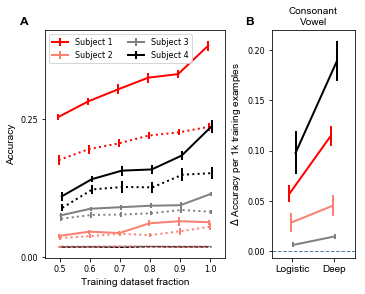

In [15]:
# reload(accuracy)
reload(slope)
plt.close()
f = plt.figure(figsize=(5, 4))

le = .12
re = .02
te = .1
be = .11
h_gap = .13

w = .5
h = 1. - te - be

ax_lines = f.add_axes([le, be, w, h])
ax_slopes = f.add_axes([le + w + h_gap, be, 1. - w - h_gap - le - re, h])

key = fracs[-1]

slope.plot_cv_slope(subjects, deep_all, linear_all, chance[0], training_size, fracs, (ax_lines, ax_slopes),
                    legend=True, normalize_chance=False)

x0 = .05
y0 = 1. - te + .02
x1 = le + w + h_gap - .075

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope2.eps'), dpi=300)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/slope2.png'), dpi=300)